In [1]:
# load test dataset
import numpy as np

input_and_output = np.load("../final/dataset.npz")
inputs  = input_and_output["inputs"].astype(np.float64)
outputs = input_and_output["outputs"].astype(np.float64)

dataset_size = inputs.shape[0]
train_size = int(dataset_size * 0.7)
test_size = int(dataset_size * 0.15)

inputs_test = inputs[train_size:(train_size + test_size), :]
outputs_test = outputs[train_size:(train_size + test_size), :]

print(f"test sizes: {inputs_test.shape}, {outputs_test.shape}")

test sizes: (150000, 11), (150000, 200)


In [2]:
# load model
from sklearn.preprocessing import MinMaxScaler
import pickle
import json
import cpuinfo
import optuna
from pathlib import Path


LOWER_LIMIT = -9
LOGNORMAL_PARAMETERS = (1, 2)
PCA_COMPONENTS=12

def output_transform(outputs: np.array) -> np.array:
    x = np.copy(outputs)
    zeros_in_output = x <= 0
    x[zeros_in_output] = 1
    y = np.log10(x)
    y[zeros_in_output] = LOWER_LIMIT
    y[y < LOWER_LIMIT] = LOWER_LIMIT
    return y

def output_untransform(transformed_outputs: np.array) -> np.array:
    lower_limits = transformed_outputs <= LOWER_LIMIT
    z = 10 ** transformed_outputs
    z[lower_limits] = 0
    return z

def drop_treatment(input_data: np.ndarray) -> np.ndarray:
    """Drops treatment data from the dataset"""
    if input_data.shape[1] == 11:
        return input_data[:, 1:]
    return input_data

class CustomScaler:
    def __init__(self):
        super().__init__()
        self.scaler = MinMaxScaler()
        self.plot_loval = [0.0] * len(LOGNORMAL_PARAMETERS)
        self.plot_hival = [1.0] * len(LOGNORMAL_PARAMETERS)

    def transform(self, x: np.ndarray, copy=None) -> np.ndarray:
        res = self.scaler.transform(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            res[:, parameter_index] = (x[:, parameter_index] - self.plot_loval[i]) / (self.plot_hival[i] - self.plot_loval[i])

        return res

    def fit(self, x, copy=None):
        self.scaler.fit(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            column_values = x[:, parameter_index]

            quantile_1, quantile_3 = np.quantile(column_values, [0.25, 0.75], axis=0)
            iqr = quantile_3 - quantile_1

            loval = quantile_1 - 1.5 * iqr
            hival = quantile_3 + 1.5 * iqr

            wiskhi = np.compress(column_values <= hival, column_values)
            wisklo = np.compress(column_values >= loval, column_values)
            actual_hival = np.max(wiskhi)
            actual_loval = np.min(wisklo)

            self.plot_loval[i] = actual_loval
            self.plot_hival[i] = actual_hival

        return self

    def inverse_transform(self, x, copy=None):
        res = self.scaler.inverse_transform(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            res[:, parameter_index] = x[:, parameter_index] * (self.plot_hival[i] - self.plot_loval[i]) + self.plot_loval[i]
        return res

with Path(f"../final/scaler.pickle").open("rb") as scaler_file:
    scaler = pickle.load(scaler_file)
        
from sklearn.decomposition import PCA

pca = None
with Path(f"../final/pca{PCA_COMPONENTS}.pickle").open("rb") as opened_file:
    pca = pickle.load(opened_file)

regressor = None
regressor_path = Path(f"../final/MLPRegressor.pickle")

if regressor_path.exists():
    with regressor_path.open("rb") as opened_file:
        regressor = pickle.load(opened_file)
else:
    X_train_scaled = scaler.transform(drop_treatment(inputs[:train_size, :]))
    Y_train_pca = transform(output_transform(outputs[:train_size, :]))
    trail = optuna.load_study(study_name="MLPRegressor", storage='sqlite:///../final/optuna.db').best_trial
    model = MLPRegressor(**trial.user_attrs["model_params"])
    model.fit(X_train_scaled[:trial.user_attrs["training_size"], :], 
              Y_train_pca[:trial.user_attrs["training_size"], :])

    with regressor_path.open("wb") as opened_file:
        pickle.dump(model, opened_file)

    metadata = {
        "model_params": params,
        "train_dataset": "prefix 700000 of ../final/dataset.npz",
        "optuna": {
            "study_name": "MLPRegressor",
            "optimized_params": ["alpha", "learning_rate", "learning_rate_init", "hidden_layer_sizes", "power_t"],
            "description": "started with 3% of data and increasing it to 100% with trial number, simultaneously increasing max_iterations and batch_size. Added a timeout to interrupt models not fitting in reasonable limits."
        },
        "test_error": "6.325262407758518e-05",
        "test_dataset": "[700000:850000] of ../final/dataset.npz",
        "cpu_info": {k:v for k,v in cpuinfo.get_cpu_info().items() if k in ('arch', 'bits', 'brand_raw', 'count', 'l2_cache_size')}
    }

    with Path(f"../final/MLPRegressor_metadata.json").open("w") as opened_file:
        metadata_string = json.dumps(metadata, sort_keys=True, indent=4)
        opened_file.write(metadata_string)
        print(metadata_string)
    
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    FunctionTransformer(drop_treatment),
    scaler,
    FunctionTransformer(regressor.predict),
    FunctionTransformer(pca.inverse_transform),
    FunctionTransformer(output_untransform)
)

calculated (150000, 11) in 8.831931114196777


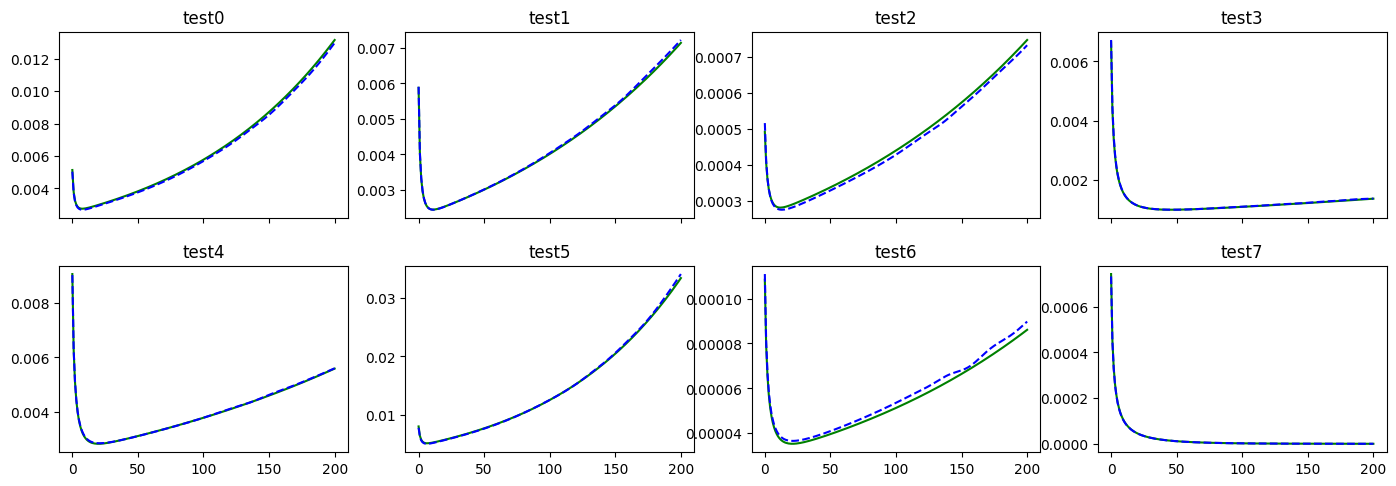

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

sample_size = 8
x_axis = np.linspace(0, 200, outputs_test.shape[1])

rows, cols = (sample_size + 3) // 4, 4
figure, axs = plt.subplots(rows, cols, sharex=True)
figure.set_size_inches(cols * 3.5, rows * 3)
figure.tight_layout(h_pad=2.4, rect=(0, 0, 1, 1.0 - 0.4 / rows))

import time 
start_time = time.time()
predictions = model.transform(inputs_test)
print(f"calculated {inputs_test.shape} in {time.time() - start_time}")

for row in range(rows):
    for col in range(cols):
        i = row * cols + col
        if i < sample_size:
            axs[row, col].set_title(f"test{i}")
            axs[row, col].plot(x_axis, outputs_test[i, :], color='green')
            axs[row, col].plot(x_axis, predictions[i, :], color='blue', linestyle='dashed')

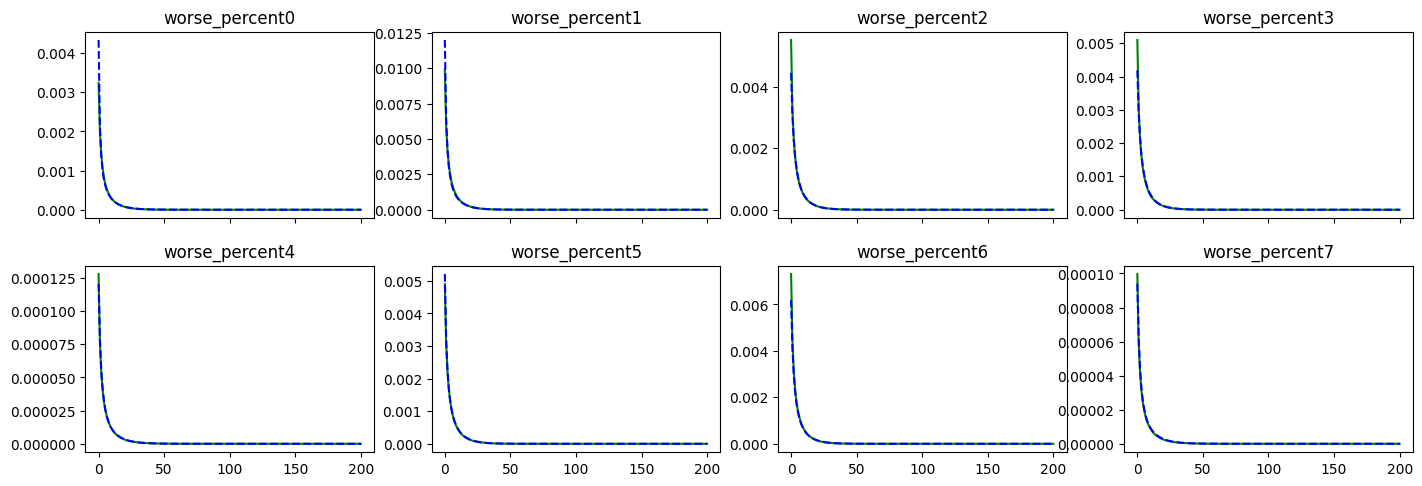

In [16]:
import matplotlib.pyplot as plt

figure, axs = plt.subplots(rows, cols, sharex=True)
figure.set_size_inches(cols * 3.5, rows * 3)
figure.tight_layout(h_pad=2.4, rect=(0, 0, 1, 1.0 - 0.4 / rows))

a = np.amax(np.divide(np.absolute(outputs_test - predictions), outputs_test), axis=1)
ind = np.argpartition(a, -sample_size)[-sample_size:]

for row in range(rows):
    for col in range(cols):
        i = row * cols + col
        if i < sample_size:
            axs[row, col].set_title(f"worse_percent{i}")
            axs[row, col].plot(x_axis, outputs_test[ind[i], :], color='green') 
            axs[row, col].plot(x_axis, predictions[ind[i], :], color='blue', linestyle='dashed')

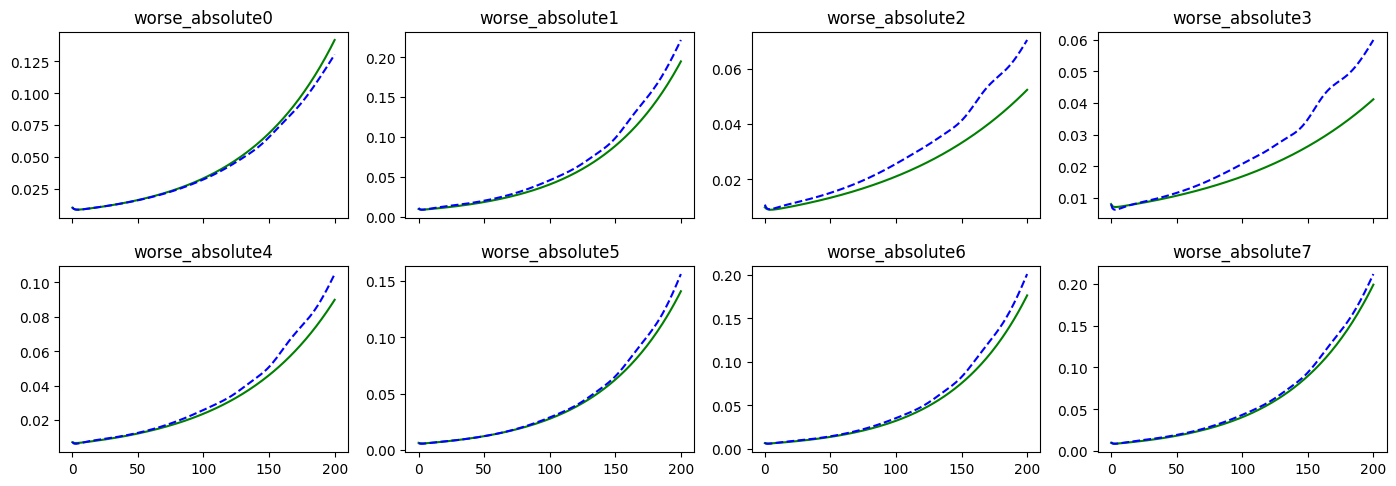

In [17]:
import matplotlib.pyplot as plt

figure, axs = plt.subplots(rows, cols, sharex=True)
figure.set_size_inches(cols * 3.5, rows * 3)
figure.tight_layout(h_pad=2.4, rect=(0, 0, 1, 1.0 - 0.4 / rows))

a = np.amax(np.absolute(outputs_test - predictions), axis=1)
ind = np.argpartition(a, -sample_size)[-sample_size:]

for row in range(rows):
    for col in range(cols):
        i = row * cols + col
        if i < sample_size:
            axs[row, col].set_title(f"worse_absolute{i}")
            axs[row, col].plot(x_axis, outputs_test[ind[i], :], color='green') 
            axs[row, col].plot(x_axis, predictions[ind[i], :], color='blue', linestyle='dashed')